In [333]:
import sys

import pandas as pd
from matplotlib import pyplot as plt

from processing.sanitization import get_sample_data
from processing.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE
from processing.linear_regression import get_regression, LinearRegressionData
from processing.uncertainty import compute_uncertainty
from typing import Optional

sys.path.append("../")

In [334]:
from typing import List


def prepare_data(path: str, sort_ascending: Optional[bool] = True) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=False, header=0)
    df.sort_values(by="U", ascending=sort_ascending)

    df["u(U)"] = [compute_uncertainty(v, BRYMEN_BM811_VOLTAGE) for v in df["U"]]
    df["u(I)"] = [compute_uncertainty(i, BRYMEN_BM811_CURRENT) for i in df["I"]]

    return df


def merge_data(path_1: str, path_2: str) -> pd.DataFrame:
    df1 = prepare_data(path_1)
    df2 = prepare_data(path_2)
    df_result = pd.concat([df1, df2])

    df_result.sort_values(by="U", inplace=True)
    df_result.drop(df_result.tail(10).index, inplace=True)
    df_result.drop(df_result.head(10).index, inplace=True)

    df_result.to_csv("out.csv")

    return df_result


def plot_zener_with_regression(
    df: pd.DataFrame, forward_sample: int, reverse_sample: int
) -> List[LinearRegressionData]:
    forward_regr_voltage = df["U"][-reverse_sample:].to_numpy()
    forward_regr_current = df["I"][-reverse_sample:].to_numpy()

    reverse_regr_voltage = df["U"][:forward_sample].to_numpy()
    reverse_regr_current = df["I"][:forward_sample].to_numpy()

    forward_data, forward_vals, forward_model = get_regression(
        forward_regr_voltage, forward_regr_current
    )
    reverse_data, reverse_vals, reverse_model = get_regression(
        reverse_regr_voltage, reverse_regr_current
    )

    plt.figure()
    plt.grid()
    plt.xlabel("U[mV]")
    plt.ylabel("I[mA]")
    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)
    plt.plot(forward_vals, forward_model.predict(forward_vals), color="red")
    plt.plot(reverse_vals, reverse_model.predict(reverse_vals), color="orange")
    plt.show()

    return [forward_data, reverse_data]


def plot_with_regression(df: pd.DataFrame) -> LinearRegressionData:
    regr_voltage = df["U"][-30:].to_numpy()
    regr_current = df["I"][-30:].to_numpy()

    data, vals, model = get_regression(regr_voltage, regr_current)

    plt.figure()
    plt.grid()
    plt.xlabel("U[V]")
    plt.ylabel("I[A]")

    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)

    plt.plot(vals, model.predict(vals), color="orange")
    plt.plot(vals, model.predict(vals), color="orange")

    plt.show()

    return data


def sample_data_presentation(df_1: pd.DataFrame, df_2: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_1[0:40], df_2[0:40]], axis=1)

# Rectifying

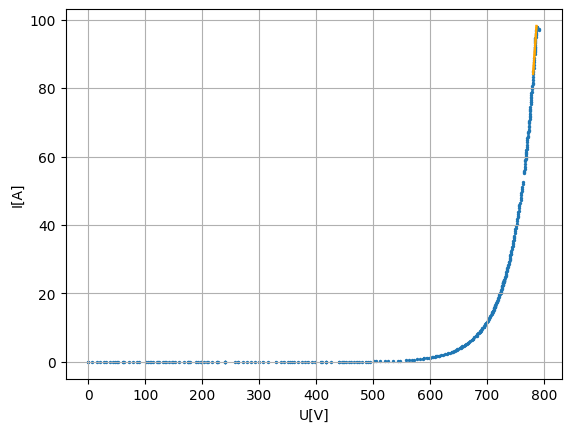

a=2.341667016347249 b=-1744.7252745628357
       U          I      u(U)      u(I)
0      0  -0.010000  0.011547  0.000230
40   190  -0.010000  0.143183  0.000230
80   393   0.000000  0.283825  0.000231
120  594   1.100000  0.423082  0.000358
160  675   6.570000  0.479201  0.000990
200  713  15.860000  0.505528  0.002062
240  727  22.219999  0.515227  0.002797
280  750  38.119999  0.531162  0.004633
320  769  62.000000  0.544326  0.007390
360  780  82.400002  0.551947  0.009746


In [335]:
data = prepare_data("data/multimeter_data/sanitized/rectifying.csv")
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_with_regression(data)

print(linear_regression_coeffs)
display(sample)

# Zener diode 2

,U,I,u(U),u(I),U,I,u(U),u(I)
0,0,-0.010000,0.011547,0.000230,0,-0.010000,0.011547,0.000230
1,851,96.400002,0.601137,0.011362,-2731,-71.699997,1.880545,0.008048
2,21,-0.010000,0.026096,0.000230,-2730,-71.900002,1.879852,0.008071
3,27,-0.010000,0.030253,0.000230,-35,-0.010000,0.012702,0.000230
4,33,-0.010000,0.034410,0.000230,-48,-0.010000,0.021708,0.000230
5,40,-0.010000,0.039260,0.000230,-58,-0.010000,0.028637,0.000230
6,46,-0.010000,0.043417,0.000230,-72,-0.010000,0.038336,0.000230
7,53,-0.010000,0.048266,0.000230,-85,-0.010000,0.047343,0.000230
8,59,-0.010000,0.052423,0.000230,-107,-0.010000,0.062585,0.000230
9,67,-0.010000,0.057966,0.000230,-134,-0.010000,0.081291,0.000230


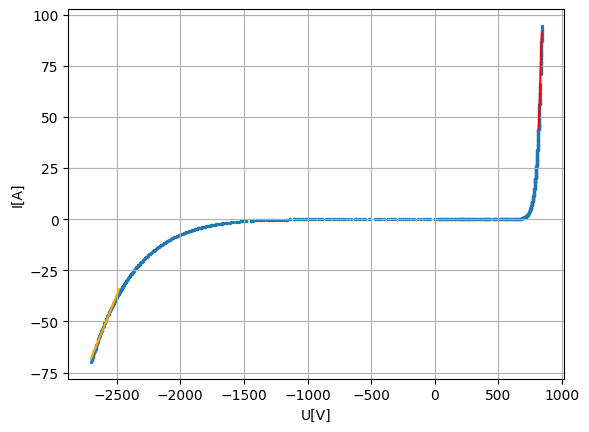

[LinearRegressionData(a=1.9428692555769962, b=-1544.9816677874558), LinearRegressionData(a=0.1540382294375489, b=348.0056482419723)]


In [336]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-2.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-2.csv")

sample = sample_data_presentation(forward, reverse)
display(sample)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-2.csv",
    "data/multimeter_data/sanitized/zener-z-2.csv",
)
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_zener_with_regression(data, 100, 100)
print(linear_regression_coeffs)

,U,I,u(U),u(I),U,I,u(U),u(I)
0,-1,-0.010000,0.010854,0.000230,-3321,-64.300003,2.289309,0.007194
1,845,96.599998,0.596980,0.011385,0,-0.010000,0.011547,0.000230
2,19,-0.010000,0.024711,0.000230,-3330,-64.099998,2.295545,0.007171
3,20,-0.010000,0.025403,0.000230,-3327,-64.000000,2.293466,0.007159
4,27,-0.010000,0.030253,0.000230,-3326,-64.000000,2.292773,0.007159
5,32,-0.010000,0.033717,0.000230,-3324,-63.900002,2.291388,0.007148
6,36,-0.010000,0.036489,0.000230,-3321,-63.599998,2.289309,0.007113
7,37,-0.010000,0.037181,0.000230,-3318,-63.299999,2.287231,0.007078
8,42,-0.010000,0.040645,0.000230,-3316,-63.200001,2.285845,0.007067
9,50,-0.010000,0.046188,0.000230,-3313,-62.799999,2.283767,0.007021


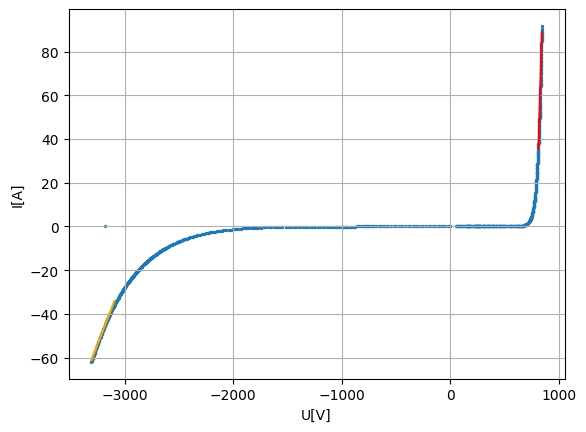

[LinearRegressionData(a=1.71506251249461, b=-1356.8784539767948), LinearRegressionData(a=0.12740820987426146, b=360.08489983782937)]


In [337]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-3.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-3.csv")

sample = sample_data_presentation(forward, reverse)
display(sample)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-3.csv",
    "data/multimeter_data/sanitized/zener-z-3.csv",
)
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_zener_with_regression(data, 100, 100)
print(linear_regression_coeffs)

,U,I,u(U),u(I),U,I,u(U),u(I)
0,0,-0.010000,0.011547,0.000230,0,-0.01,0.011547,0.000230
1,861,96.300003,0.608065,0.011351,-4375,-50.68,3.019542,0.005621
2,25,-0.010000,0.028868,0.000230,-19,-0.01,0.001617,0.000230
3,28,-0.010000,0.030946,0.000230,-25,-0.01,0.005774,0.000230
4,29,-0.010000,0.031639,0.000230,-34,-0.01,0.012009,0.000230
5,38,-0.010000,0.037874,0.000230,-45,-0.01,0.019630,0.000230
6,40,-0.010000,0.039260,0.000230,-53,-0.01,0.025172,0.000230
7,52,-0.010000,0.047574,0.000230,-57,-0.01,0.027944,0.000230
8,59,-0.010000,0.052423,0.000230,-64,-0.01,0.032793,0.000230
9,66,-0.010000,0.057273,0.000230,-72,-0.01,0.038336,0.000230


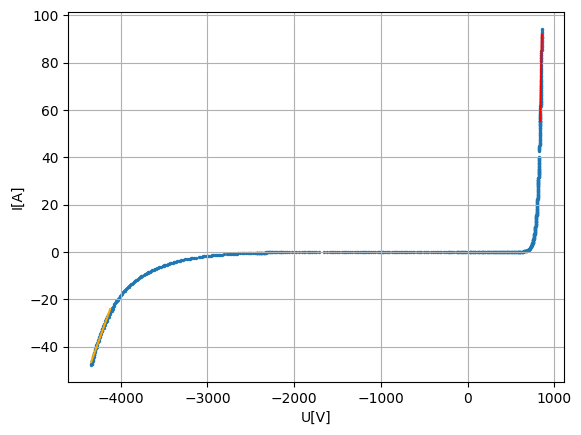

[LinearRegressionData(a=1.919456518505407, b=-1553.2209202934077), LinearRegressionData(a=0.1017760601574804, b=395.3644114296914)]


In [338]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-4.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-4.csv")

sample = sample_data_presentation(forward, reverse)
display(sample)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-4.csv",
    "data/multimeter_data/sanitized/zener-z-4.csv",
)
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_zener_with_regression(data, 100, 100)
print(linear_regression_coeffs)